# Bitcoin Price Trend Prediction with CNN (Elon Musk Tweets)

Previous dataset quality has impacted the performance of models, and we decide to experiment with the tweets from renowned people in the industry. And we managed to collect the data for Elon Musk's tweets.

## Setup

In [18]:
import emoji
import numpy as np
import pandas as pd
import re
import seaborn as sn
import torch
import torchtext
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchtext

from sklearn import metrics
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import preprocessor as tp

In [4]:
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from collections import Counter, OrderedDict

## Preprocess

In [6]:
df = pd.read_csv('../../data/elon-tweets-with-price.csv')

In [7]:
df.head()

,Tweet,UserScreenName,UserName,Timestamp,text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,next_15min_prices
0,6745,Elon Musk,@elonmusk,2019-12-01T08:48:16.000Z,Do you like our owl?\n12.3K\n23.2K\n381K,NaN,12.3K,23.2K,381K,['https://pbs.twimg.com/media/EKsGGK2VAAEebP7?...,https://twitter.com/elonmusk/status/1201060433...,"[7295.18, 7302.52, 7293.29, 7288.96, 7290.42, ..."
1,6746,Elon Musk,@elonmusk,2019-12-02T23:18:08.000Z,"People often think they’re breathing oxygen, b...",NaN,"6,946",42.3K,310.6K,[],https://twitter.com/elonmusk/status/1201641730...,"[7303.8, 7305.86, 7309.29, 7307.96, 7304.52, 7..."
2,6747,Elon Musk,@elonmusk,2019-12-02T20:45:14.000Z,"Hydrogen is a light, odorless gas, which, give...",NaN,"2,580",12.3K,164.3K,[],https://twitter.com/elonmusk/status/1201603251...,"[7309.0, 7303.1, 7303.06, 7301.56, 7298.67, 72..."
3,6748,Elon Musk,@elonmusk,2019-12-01T09:05:11.000Z,"It’s artificial\n3,116\n2,551\n107K",NaN,"3,116","2,551",107K,[],https://twitter.com/elonmusk/status/1201064688...,"[7302.47, 7291.24, 7300.91, 7295.35, 7294.61, ..."
4,6749,Elon Musk,@elonmusk,2019-12-04T02:45:24.000Z,Launching third flight of this Dragon spacecra...,NaN,645,"2,042",31K,['https://pbs.twimg.com/profile_images/1082744...,https://twitter.com/elonmusk/status/1202056276...,"[7134.75, 7131.65, 7132.83, 7134.59, 7138.02, ..."


### Clean data

Remove useless features.

In [8]:
df_pre = df.drop(['Tweet', 'UserScreenName', 'UserName', 'Timestamp', 'Image link', 'Tweet URL'], axis=1)

In [9]:
df_pre.head()

,text,Emojis,Comments,Likes,Retweets,next_15min_prices
0,Do you like our owl?\n12.3K\n23.2K\n381K,NaN,12.3K,23.2K,381K,"[7295.18, 7302.52, 7293.29, 7288.96, 7290.42, ..."
1,"People often think they’re breathing oxygen, b...",NaN,"6,946",42.3K,310.6K,"[7303.8, 7305.86, 7309.29, 7307.96, 7304.52, 7..."
2,"Hydrogen is a light, odorless gas, which, give...",NaN,"2,580",12.3K,164.3K,"[7309.0, 7303.1, 7303.06, 7301.56, 7298.67, 72..."
3,"It’s artificial\n3,116\n2,551\n107K",NaN,"3,116","2,551",107K,"[7302.47, 7291.24, 7300.91, 7295.35, 7294.61, ..."
4,Launching third flight of this Dragon spacecra...,NaN,645,"2,042",31K,"[7134.75, 7131.65, 7132.83, 7134.59, 7138.02, ..."


### Emojis

Convert emoji to text.

In [35]:
def replace_emoji(row):
    if pd.isna(row['Emojis']):
        return ""
    else:
        return emoji.demojize(row['Emojis'], delimiters=("", "")).replace('_', ' ')

In [36]:
df_pre['emoji_text'] = df_pre.apply(replace_emoji, axis=1)

In [37]:
df_pre['emoji_text'].value_counts()

                                                               4929
rolling on the floor laughing rolling on the floor laughing     140
rolling on the floor laughing                                    73
hundred points                                                   25
fire fire                                                        20
                                                               ... 
cat                                                               1
ship rocket                                                       1
rocket heart suit                                                 1
rolling on the floor laughing two hearts                          1
collision                                                         1
Name: emoji_text, Length: 144, dtype: int64

In [30]:
emoji_counter = Counter()
for emojis in df_pre["emoji_text"]:
    for e in emojis:
        emoji_counter[e] += 1
emoji_set = sorted(emoji_counter.items(), key=lambda x: x[1], reverse=True)
print(len(emoji_set))

122


### Preprocess tweet

1. Use Twitter-Processor to clean the tweet, including URL/mention/hashtag removing.

In [38]:
def preprocess_tweet(text):
    text = tp.clean(text)
    return text

In [44]:
df_pre['clean_text'] = df_pre['text'].apply(preprocess_tweet)

In [50]:
df_pre.loc[:,['text', 'clean_text']].head()


,text,clean_text
0,Do you like our owl?\n12.3K\n23.2K\n381K,do you like our owl
1,"People often think they’re breathing oxygen, b...",people often think theyre breathing oxygen but...
2,"Hydrogen is a light, odorless gas, which, give...",hydrogen is a light odorless gas which given e...
3,"It’s artificial\n3,116\n2,551\n107K",its artificial
4,Launching third flight of this Dragon spacecra...,launching third flight of this dragon spacecra...


2. Lowercase the text, remove punctuation, extra space and digits.

In [45]:
df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kK]*', '')

/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_46237/2324435351.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kK]*', '')


3. Append emoji text to tweet text.

In [47]:
def concatenate_text(row):
    if len(row['emoji_text']) == 0:
        return row['clean_text']
    return row['clean_text'] + ' ' + row['emoji_text']

In [48]:
df["clean_text"] = df_pre.apply(concatenate_text, axis=1)

4. Lemmatize and tokenize the text.

In [51]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))

In [52]:
def lemmatize_tweet(row):
    text = row['clean_text']
    return [(lemmatizer.lemmatize(w)) for w in \
                                     w_tokenizer.tokenize((text))]

In [53]:
df_pre['clean_text'] = df_pre.apply(lemmatize_tweet, axis=1)

In [60]:
df_pre.loc[:,['text', 'clean_text']].head()

,text,clean_text
0,Do you like our owl?\n12.3K\n23.2K\n381K,"[do, you, like, our, owl]"
1,"People often think they’re breathing oxygen, b...","[people, often, think, theyre, breathing, oxyg..."
2,"Hydrogen is a light, odorless gas, which, give...","[hydrogen, is, a, light, odorless, gas, which,..."
3,"It’s artificial\n3,116\n2,551\n107K","[it, artificial]"
4,Launching third flight of this Dragon spacecra...,"[launching, third, flight, of, this, dragon, s..."


### Label

Define the label using bitcoin prices:
* If the average price for next 15 minutes increases more than 1%, we consider the tweet will lead to an "increase" of price. 
* If the average price for next 15 minutes drops more than 1%, we consider the tweet will lead to the "decrease" of price. 
* Else, we consider the tweet has "no change" to the price.

In [ ]:
#df = pd.read_csv("preprocess.csv")

In [55]:
label_map = {"no change": 0, "decrease": 1, "increase": 2}

In [56]:
def getLabel(row):
    raw = row["next_15min_prices"].split(',')
    prices = [float(re.sub('[\s\[\]]+','', w)) for w in raw]
    #print(len(prices))
    #print(prices)
    mean = np.mean(prices[1:])
    r = np.divide(mean - prices[0], prices[0]) * 100
    if r > 1:
        return 2
    if r < -1:
        return 1
    return 0

In [57]:
df_pre["label"] = df_pre.apply(getLabel, axis=1)

In [58]:
df_pre["label"].value_counts()

0    5418
2      26
1      15
Name: label, dtype: int64

In [ ]:
df_ready = df_pre.drop(['next_15min_prices'], axis=1)

In [59]:
df_pre.head()

,text,Emojis,Comments,Likes,Retweets,next_15min_prices,emoji_text,clean_text,label
0,Do you like our owl?\n12.3K\n23.2K\n381K,NaN,12.3K,23.2K,381K,"[7295.18, 7302.52, 7293.29, 7288.96, 7290.42, ...",,"[do, you, like, our, owl]",0
1,"People often think they’re breathing oxygen, b...",NaN,"6,946",42.3K,310.6K,"[7303.8, 7305.86, 7309.29, 7307.96, 7304.52, 7...",,"[people, often, think, theyre, breathing, oxyg...",0
2,"Hydrogen is a light, odorless gas, which, give...",NaN,"2,580",12.3K,164.3K,"[7309.0, 7303.1, 7303.06, 7301.56, 7298.67, 72...",,"[hydrogen, is, a, light, odorless, gas, which,...",0
3,"It’s artificial\n3,116\n2,551\n107K",NaN,"3,116","2,551",107K,"[7302.47, 7291.24, 7300.91, 7295.35, 7294.61, ...",,"[it, artificial]",0
4,Launching third flight of this Dragon spacecra...,NaN,645,"2,042",31K,"[7134.75, 7131.65, 7132.83, 7134.59, 7138.02, ...",,"[launching, third, flight, of, this, dragon, s...",0


### Create vocabulary

Create vocabulary based on cleaned text. 

In [61]:
text_counter = Counter()
for text in df_pre["clean_text"]:
    for w in text:
        text_counter[w] += 1
text_counter['<unk>'] = 1
text_counter_sorted = sorted(text_counter.items(), key=lambda x: x[1], reverse=True)
print(len(text_counter.items()))

7347


In [62]:
token_ordered_dict = OrderedDict(text_counter_sorted)

vocabulary = torchtext.vocab.Vocab(token_ordered_dict, specials=['<unk>'], specials_first=True)
#vocabulary.set_default_index(vocabulary['<unk>'])

print("Number of tokens: {}".format(len(vocabulary)))

Number of tokens: 7347


### Numericalization

Convert text tokens to indices, add padding to provide a constant length for all according to the maximum length.

In [63]:
def sequence(tokens):
    return [vocabulary.__getitem__(t) for t in tokens]

In [64]:
df_pre['text_seq'] = df_pre['clean_text'].apply(sequence)

In [66]:
df_pre = df_pre.drop(['Emojis','text','clean_text','next_15min_prices','emoji_text'], axis=1)

In [67]:
df_pre.head()

,Comments,Likes,Retweets,label,text_seq
0,12.3K,23.2K,381K,0,"[42, 26, 48, 54, 6061]"
1,"6,946",42.3K,310.6K,0,"[67, 1095, 143, 461, 2786, 655, 16, 18, 163, 2..."
2,"2,580",12.3K,164.3K,0,"[750, 6, 5, 356, 5840, 446, 71, 497, 220, 44, ..."
3,"3,116","2,551",107K,0,"[10, 2124]"
4,645,"2,042",31K,0,"[1200, 1708, 121, 7, 17, 194, 660, 1, 7033, 65..."


In [68]:
len(max(df_pre['text_seq'], key=len))

78

In [81]:
def padding(ls, min_len):
    if len(ls) < min_len:
        ls = ls + [0] * max(0, min_len - len(ls))
    return ls

In [82]:
df_pre['text_seq'] = df_pre['text_seq'].apply(lambda x: padding(x, 78))

## Train

In [69]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [91]:
X = np.array([np.array(x) for x in df_pre['text_seq'].values])

Split the data into train and test(validation) set.

In [94]:
x_train, x_test, y_train, y_test = train_test_split(X, df_pre['label'].values, test_size=0.2, shuffle=True, random_state=0)


In [96]:
x_train.shape

(4367, 78)

In [97]:
train_loader = DataLoader(list(zip(x_train, y_train)), shuffle=False, batch_size=32)
test_loader = DataLoader(list(zip(x_test, y_test)), shuffle=False, batch_size=32)

Training and validation functions, with reference to notebooks in class.

In [73]:
def train_epoch(model, loader, optimizer, criterion):
    
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):
            
            # get the batch; batch is a list of [text, label]
            X_batch, y_batch = batch   

            log_probs = model(X_batch)        

            # Calculate loss
            loss = criterion(log_probs, y_batch)
            
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of overall epoch loss
            epoch_loss += loss.item()   
            
    return epoch_loss

In [74]:
def plot_confusion_matrix(y_true, y_predict):
    confmat = ConfusionMatrix(task='multiclass', num_classes=3).to(device)
    matrix = confmat(np.array(y_true), np.array(y_predict)).cpu()

    classes = ["no change", "decrease", "increase"]

    df_cm = pd.DataFrame(matrix, index = [i for i in classes],
                      columns = [i for i in classes])
    df_cm = df_cm.astype(float)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel('predictions', fontsize =14)
    plt.ylabel('ground truth', fontsize =14)
    

In [75]:
def evaluate(model, loader, plot=False):
    
    y_true, y_pred = [], []
    
    for batch_idx, batch in enumerate(loader):
            
        # get the batch; batch is a list of [text, label]
        X_batch, y_batch = batch
            
        log_probs = model(X_batch)                

        y_batch_pred = torch.argmax(log_probs, dim=1)

        y_true += list(y_batch.cpu())
        y_pred += list(y_batch_pred.cpu())
        
    if plot:
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,  display_labels = ["no change", "decrease", "increase"])
        cm_display.plot()
        plt.show()
    return metrics.f1_score(y_true, y_pred, average='micro')

In [76]:
def train(model, loader_train, loader_test, optimizer, criterion, num_epochs):
    
    results = []
    
    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    #for epoch in tqdm(range(1, num_epochs+1)):
    for epoch in range(1, num_epochs+1):        
        model.train()
        epoch_loss = train_epoch(model, loader_train, optimizer, criterion)
        model.eval()
        acc_train = evaluate(model, loader_train)
        plot = False
        if epoch == num_epochs:
            plot = True
        acc_test = evaluate(model, loader_test, plot)

        results.append((epoch_loss, acc_train, acc_test))
        
        #if epoch % 10 == 0:
        print("[Epoch {}] loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} ".format(epoch, epoch_loss, acc_train, acc_test))
            
    return results

Load pretrained embedding vectors "English Wikipedia Dump of February 2017", source http://vectors.nlpl.eu/repository/.

In [77]:
# embedding vectors file not included in the repo
pretrained_vectors = torchtext.vocab.Vectors("5/model.txt")
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(vocabulary.itos)

Define the model structure.

In [101]:
#Defining the convolutional neural network
class CNN(nn.Module):
            
    def __init__(self, embedding_dim, hidden_size, vocab_size, output_size, feature_size, kernel_sizes=[3,4,5]):
        super(CNN, self).__init__()
        self.feature_size = feature_size
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        
        # 2. convolutional layers
        
        self.conv1 = nn.ModuleList([
            nn.Conv2d(1, hidden_size, (k, embedding_dim), padding=(k-2,0)) 
            for k in kernel_sizes])
        #self.conv2 = nn.Conv1d(feature_size, hidden_size, kernel_size=2)
        
        # 3. final, fully-connected layer for classification
        
        self.fc = nn.Linear(len(kernel_sizes) * hidden_size, output_size) 
        
        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def conv_and_pool(self, x, conv):
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = self.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        embeds = self.embedding(x).unsqueeze(1)

        x_conv = [self.conv_and_pool(embeds, conv) for conv in self.conv1]

        x = torch.cat(x_conv, dim=1)
        x = self.dropout(x)
        output = self.fc(x) 
        return self.sig(output)

In [105]:
cnn = CNN(embedding_dim=300, hidden_size=64, vocab_size=len(vocabulary), output_size=3, feature_size=5)
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)
#criterion = nn.NLLLoss()
# weight_i = total_samples / (num_samples_in_i * output_size)
#weights = [0.34, 32.78, 24.87]
weights = [0.01, 45, 55]
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
cnn.embedding.weight.data = pretrained_embedding
cnn.embedding.weight.requires_grad = True
cnn.to(device)

CNN(
  (embedding): Embedding(7347, 300)
  (conv1): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1), padding=(3, 0))
  )
  (fc): Linear(in_features=192, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sig): Sigmoid()
)

Total Training Time (total number of epochs: 5)
[Epoch 1] loss:	135.353, f1 train: 0.992, f1 test: 0.993 
[Epoch 2] loss:	115.433, f1 train: 0.992, f1 test: 0.993 
[Epoch 3] loss:	110.164, f1 train: 0.992, f1 test: 0.993 
[Epoch 4] loss:	108.323, f1 train: 0.992, f1 test: 0.993 


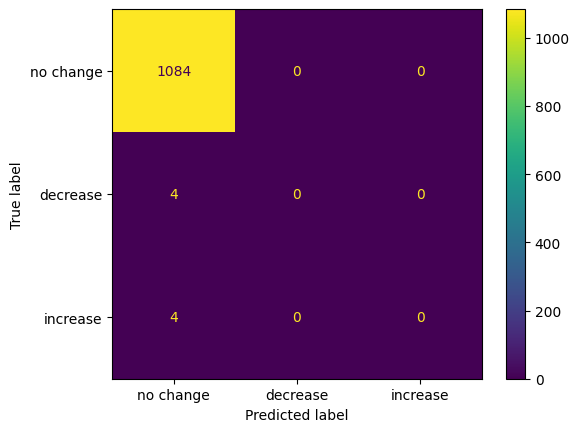

[Epoch 5] loss:	107.925, f1 train: 0.992, f1 test: 0.993 


In [106]:
num_epochs = 5
new_results = train(cnn, train_loader, test_loader, optimizer, criterion, num_epochs)

Overall, the performance is still not satisfying. The dataset is quite small, with only around 50 tweets that are labelled to have impact on Bitcoin price, which is not enough for model to learn any useful features.